In [1]:
# First we grab the model and the unembedding weight matrix
import torch
from easy_transformer import EasyTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

unembed = model.unembed.W_U.data
unembed_bias = model.unembed.b_U.data
d_model = model.cfg.d_model
d_vocab = model.cfg.d_vocab

/home/giles/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
Loading model: gpt2


Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu


In [2]:
    
# Convenience function for decoding token
decode = model.tokenizer.decode

def decode_pad(t):
    string = decode(t)
    return f'{string:10}'

# Turn the embedding vector into a set of token probabilities
def embed_vector_to_probs(v):
    if v.shape != (d_model,):
        raise Exception(f"Shape should be [{d_model}], got {v.shape}")
    logits = torch.matmul(v.to(device), unembed)
    return torch.nn.functional.softmax(logits, dim=0)

# A function for understanding a vector in embedding space
def print_embed_vector(v):
    if v.shape != (d_model,):
        raise Exception(f"Shape should be [{d_model}], got {v.shape}")
    logits = torch.matmul(v.to(device), unembed)
    probs = torch.nn.functional.softmax(logits, dim=0)
    values = [(v.item(),i) for i,v in enumerate(logits)]
    values.sort(reverse=True)
    for i in range(10):
        j = values[i][1]
        print(f'{decode_pad(j)} {values[i][0]} {probs[j]}')
    print('  ...')
    for i in range(d_vocab-5,d_vocab):
        j = values[i][1]
        print(f'{decode_pad(j)} {values[i][0]} {probs[j]}')


In [3]:
# Choose some nouns from nltk
from nltk.corpus import wordnet as wn
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

num_wanted = 100
seen = set()
chosen_tokens = []
for synset in wn.all_synsets('n'):
    tok = ' ' + synset.name().split('.')[0]
    enc = model.tokenizer.encode(tok)
    if len(enc) == 1 and tok not in seen:
        chosen_tokens.append(enc[0])
        seen.add(tok)

import random
random.seed(12345)
chosen_tokens = random.sample(chosen_tokens, k=num_wanted)
        
print(list(decode(t) for t in chosen_tokens))

[nltk_data] Downloading package omw-1.4 to /home/giles/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/giles/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[' cyan', ' stiff', ' emergence', ' venom', ' midnight', ' prosperity', ' groin', ' tablespoon', ' hearing', ' compact', ' challenge', ' preference', ' dating', ' tongue', ' role', ' height', ' capacitor', ' chat', ' civilization', ' siege', ' salad', ' profiling', ' constraint', ' shoulder', ' undergraduate', ' stranger', ' cooperation', ' fingerprint', ' tell', ' ancestry', ' concussion', ' substantive', ' ceremony', ' inspection', ' awakening', ' pedestrian', ' upset', ' riot', ' ranch', ' motel', ' drive', ' technique', ' puck', ' traction', ' poem', ' counselor', ' graves', ' gray', ' space', ' interchange', ' ob', ' listing', ' decimal', ' recoil', ' affairs', ' fabric', ' football', ' peak', ' grain', ' song', ' bartender', ' karma', ' government', ' totalitarian', ' transistor', ' stag', ' ordinance', ' intoxication', ' loader', ' noon', ' panel', ' arsenic', ' assignment', ' kid', ' visitation', ' conservatism', ' cere', ' traitor', ' lack', ' gall', ' indic', ' god', ' confin

In [4]:
# Attempt to calculate the "auspicious vectors" using the Moore-Penrose pseudoinverse
ausp1 = torch.nn.functional.normalize(torch.linalg.pinv(unembed.to('cpu')), dim=1)
for t in chosen_tokens[:5]:
    print(decode(t))
    print_embed_vector(ausp1[t,:])
    print()


 cyan
 cyan      3.4879157543182373 0.0006448631756938994
 Cyan      1.8392478227615356 0.0001240109995706007
 blue      0.7618908286094666 4.22250377596356e-05
 purple    0.7578718662261963 4.205567529425025e-05
 Zy        0.7333407402038574 4.103655010112561e-05
 anth      0.7308653593063354 4.093509051017463e-05
 Purple    0.697922945022583 3.960856338380836e-05
 arsenic   0.6949665546417236 3.949163874494843e-05
 yellow    0.6649718284606934 3.832468792097643e-05
 pink      0.6600260138511658 3.8135607610456645e-05
  ...
kw         -0.514163613319397 1.1786545655922964e-05
pheus      -0.5188753008842468 1.1731141967175063e-05
WOR        -0.5266374349594116 1.164043897006195e-05
ihad       -0.5471030473709106 1.1404628821765073e-05
elle       -0.61856609582901 1.0618058695399668e-05

 stiff
 stiff     2.902953863143921 0.00035984168061986566
 stiffness 0.8167327046394348 4.467628968995996e-05
 rigid     0.8114137053489685 4.443929356057197e-05
 stern     0.7992160320281982 4.3900527

Next, we want to see if these auspicious vectors can be added to get the result we expect. The expected result is that (a + b) gives a probability vector of 50% a, 50% b.

<AxesSubplot:>

/home/giles/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


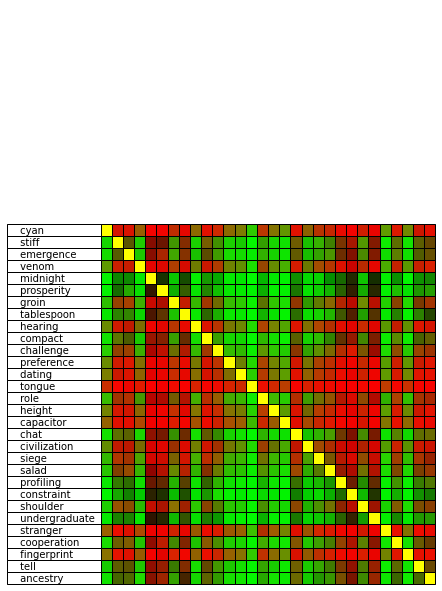

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 1]
plt.rcParams["figure.autolayout"] = True

num = 30
colors = []
for i in range(num):
    colors.append([])
    for j in range(num):
        #v1 = 30 * chosen_ausp[i,:]
        #v2 = 30 * chosen_ausp[j,:]
        v1 = 4 * ausp1[chosen_tokens[i],:]
        v2 = 4 * ausp1[chosen_tokens[j],:]
        combo = v1 + v2
        probs = embed_vector_to_probs(combo)
        r = probs[chosen_tokens[i]].item()
        g = probs[chosen_tokens[j]].item()
        b = 0
        colors[-1].append((r,g,b))
        
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellColours=colors, rowLabels=[decode(t) for t in chosen_tokens[:num]])
ax

In [15]:
def find_ausp(tok):
    enc = model.tokenizer.encode(tok)
    if len(enc) == 1:
        return ausp1[enc[0],:]
    else:
        raise Exception(f"Not a single token: {tok}")

token0 = ' midnight'
token1 = ' prosperity'
v0 = 4 * find_ausp(token0)
v1 = 4 * find_ausp(token1)
combo = v0 + v1
print_embed_vector(v0)
print()
print_embed_vector(v1)
print()
print_embed_vector(combo)

 midnight  9.323205947875977 0.17059829831123352
 noon      5.351477146148682 0.0032142139971256256
 midday    4.5583696365356445 0.0014542283024638891
 Midnight  4.197174549102783 0.001013368833810091
 dusk      3.799999713897705 0.0006812032661400735
 sunset    3.746898651123047 0.0006459742435254157
 sunrise   3.471822500228882 0.0004906267859041691
 dawn      3.1970341205596924 0.0003727451548911631
noon       3.19478440284729 0.0003719074884429574
 nighttime 3.0818898677825928 0.0003322046250104904
  ...
jar        -1.433237075805664 3.6350536447571358e-06
aunt       -1.435080885887146 3.6283588542573852e-06
jee        -1.4741277694702148 3.4894119380624034e-06
aspx       -1.5766888856887817 3.1492747893935302e-06
iasis      -1.5923244953155518 3.100417416135315e-06

 prosperity 9.962900161743164 0.27309373021125793
 prosperous 4.364867210388184 0.0010118518257513642
 Prosper   3.9723453521728516 0.0006833557272329926
 prosper   3.356039524078369 0.0003689679142553359
 wealth    3

In [ ]:
num = 30
colors = []
for i in range(num):
    colors.append([])
    for j in range(num):
        index0 = chosen_tokens[i]
        index1 = chosen_tokens[j]
        #prompt = f"If I had to choose between the{decode(index0)} and the{decode(index1)}, I would choose the"
        prompt = f"{decode(index0)}{decode(index1)}{decode(index1)}{decode(index0)}{decode(index1)}"
        logits = model(prompt)[0, -1, :]
        probs = torch.softmax(logits, dim=0)
        r = probs[index0].item()
        g = probs[index1].item()
        colors[-1].append((r,g,b))
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellColours=colors, rowLabels=[decode(t) for t in chosen_tokens[:num]])
ax

In [ ]:
num = 30
colors = []
for i in range(num):
    colors.append([])
    for j in range(num):
        index0 = chosen_tokens[i]
        index1 = chosen_tokens[j]
        prompt = f"If I had to choose between the{decode(index0)} and the{decode(index1)}, I would choose the"
        logits = model(prompt)[0, -1, :]
        probs = torch.softmax(logits, dim=0)
        r = probs[index0].item()
        g = probs[index1].item()
        colors[-1].append((r,g,b))
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellColours=colors, rowLabels=[decode(t) for t in chosen_tokens[:num]])
ax